C:\Users\ashiq\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Train data: 462, Validatation data: 99, Test data: 100


Epoch 1, Train Loss: 0.6810, Train Accuracy: 0.7684, Val Loss: 0.4996, Val Accuracy: 0.8860
Epoch 2, Train Loss: 0.5630, Train Accuracy: 0.7931, Val Loss: 0.3555, Val Accuracy: 0.8860
Epoch 3, Train Loss: 0.5746, Train Accuracy: 0.7931, Val Loss: 0.3606, Val Accuracy: 0.8860
Epoch 4, Train Loss: 0.5299, Train Accuracy: 0.7931, Val Loss: 0.4022, Val Accuracy: 0.8860
Epoch 5, Train Loss: 0.5118, Train Accuracy: 0.7931, Val Loss: 0.4235, Val Accuracy: 0.8860
Epoch 6, Train Loss: 0.5150, Train Accuracy: 0.7931, Val Loss: 0.3966, Val Accuracy: 0.8860
Epoch 7, Train Loss: 0.4995, Train Accuracy: 0.7931, Val Loss: 0.3585, Val Accuracy: 0.8860
Epoch 8, Train Loss: 0.4879, Train Accuracy: 0.7931, Val Loss: 0.3525, Val Accuracy: 0.8860
Epoch 9, Train Loss: 0.4931, Train Accuracy: 0.7931, Val Loss: 0.3552, Val Accuracy: 0.8860
Epoch 10, Train Loss: 0.4793, Train Accuracy: 0.7931, Val Loss: 0.3674, Val Accuracy: 0.8860
Epoch 11, Train Loss:

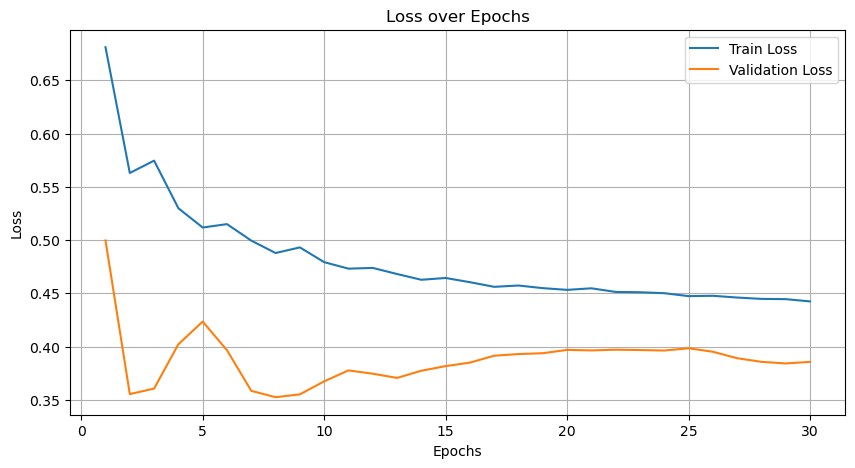

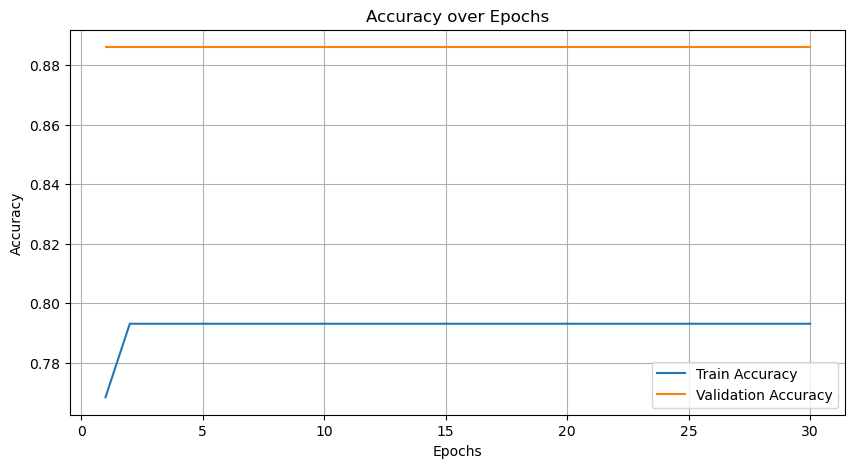


Test Loss: 0.28, Test Accuracy: 0.91


Classification Report:

               precision    recall  f1-score   support

no snowcover       0.38      0.05      0.08      3541
   snowcover       0.92      0.99      0.95     37059

    accuracy                           0.91     40600
   macro avg       0.65      0.52      0.52     40600
weighted avg       0.87      0.91      0.88     40600



Confusion matrix:

 [[  167  3374]
 [  273 36786]]




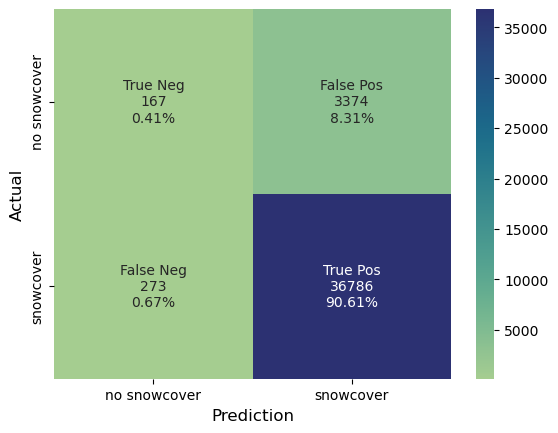

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix

import os
import re

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool as gmp

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load datasets
folder_path = "D:\\GEE\\Zugspitze\\mergebatch"

# Function to process each CSV file and generate node features and target
def process_csv(file_path, edge_index):
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Extract features (X) and target (Y)
    data['new_label'] = data['snow cover'].apply(lambda x: 0 if x <= 20 else 1)
    X = data[['x', 'y', 'year', 'month', 'precipitation', 'temperature', 'windspeed', 'elevation']].values
    Y = data['new_label'].values
    
    # Normalize features using MinMaxScaler
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    if edge_index is None:
        # Create adjacency matrix and edge index for the first batch
        knn_features = data[['year', 'month', 'x', 'y']].values
        adj = kneighbors_graph(knn_features, k, mode='connectivity', include_self=True)
        edge_index, _ = from_scipy_sparse_matrix(adj)
    
    # Create Data object for PyTorch Geometric
    graph_data = Data(
        x=torch.tensor(X, dtype=torch.float),
        edge_index=edge_index,
        y=torch.tensor(Y, dtype=torch.float)
    )
    
    return graph_data, edge_index

#Number of neighbors for each sample
k = 9

# Dictionary to hold the edge index
edge_index = None

# List to hold the data for PyTorch Geometric
data_list = []

# Function to extract numbers from filename for sorting
def extract_number(filename):
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0

# Get list of CSV files and sort them numerically
csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".csv")], key=extract_number)

# Iterate through each CSV file in the directory
for idx, filename in enumerate(csv_files, 1):
    file_path = os.path.join(folder_path, filename)
    
    # Process each file to get node features, targets, and edge index
    graph_data, edge_index = process_csv(file_path, edge_index)
    
    # Add to data list
    data_list.append(graph_data)

    # Optional: print the current status
    #print(f"Processed file {idx}: {filename}")

# Create DataLoader for mini-batching
batch_size = 661
data_loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool as gmp

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels1, hidden_channels2, hidden_channels3,hidden_channels4,hidden_channels5):
        super(GCN, self).__init__()
        # Define the GCN layers
        self.conv1 = GCNConv(num_features, hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
        self.conv4 = GCNConv(hidden_channels3, hidden_channels4)  
        self.conv5 = GCNConv(hidden_channels4, hidden_channels5)  
        self.conv6 = GCNConv(hidden_channels5, 1)  # Output single value per node for binary classification
        
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout layer with 50% probability

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Pass through the first GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        # Pass through the second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # Pass through the third GCN layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Pass through the fourth GCN layer
        x = self.conv4(x, edge_index)
        x = F.relu(x)

        # Pass through the fifth GCN layer
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        
        # Pass through the sixth GCN layer
        x = self.conv6(x, edge_index)
                
        return x

# Define number of layers
num_features = data_list[0].x.shape[1]  # Number of input features per node
hidden_channels1 = 128  
hidden_channels2 = 128  
hidden_channels3 = 64   
hidden_channels4 = 32  
hidden_channels5 = 16   

model = GCN(num_features, hidden_channels1, hidden_channels2, hidden_channels3,hidden_channels4,hidden_channels5)

def split_data(data_list, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert train_ratio + val_ratio + test_ratio == 1

    # Determine the number of data points
    num_total = len(data_list)
    num_train = int(train_ratio * num_total)
    num_val = int(val_ratio * num_total)
    num_test = num_total - num_train - num_val

    # Split the data
    train_data, temp_data = train_test_split(data_list, train_size=num_train, shuffle=False)
    val_data, test_data = train_test_split(temp_data, test_size=num_test, shuffle=False)

    return train_data, val_data, test_data

# Assuming data_list is already defined and populated
train_data, val_data, test_data = split_data(data_list)

# Create DataLoaders for each set
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f'\nTrain data: {len(train_data)}, Validatation data: {len(val_data)}, Test data: {len(test_data)}\n\n')

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize lists to store loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the number of epochs
num_epochs = 30

# Train the model
for epoch in range(num_epochs):
    total_train_loss = 0
    train_correct = 0
    total_train = 0

    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)

        target = data.y.view(-1, 1).float()  # Ensure target is float for BCEWithLogitsLoss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # For binary classification, output > 0 gives class 1
        predicted = (torch.sigmoid(output) > 0.5).float()
        train_correct += (predicted == target).sum().item()
        total_train += target.size(0)
    
    train_accuracy = train_correct / total_train
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    total_val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for data in val_loader:
            output = model(data)
            target = data.y.view(-1, 1).float()
            loss = criterion(output, target)
            total_val_loss += loss.item()

            predicted = (torch.sigmoid(output) > 0.5).float()
            val_correct += (predicted == target).sum().item()
            total_val += target.size(0)

    val_accuracy = val_correct / total_val
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Test evaluation
model.eval()
total_test_loss = 0
test_correct = 0
total_test = 0

with torch.no_grad():
    for data in test_loader:
        output = model(data)
        target = data.y.view(-1, 1)
        loss = criterion(output, target)
        total_test_loss += loss.item()
        
        predicted = output.detach().numpy().flatten()
        true_values = target.detach().numpy().flatten()

        # Apply threshold to get binary predictions
        predicted_binary = (predicted >= 0.5).astype(int)
        
        # Calculate number of correct predictions
        test_correct += (predicted_binary == true_values).sum()
        total_test += target.size(0)

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = test_correct / total_test

print(f'\nTest Loss: {avg_test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}')

# Print classification report
cr = classification_report(true_values, predicted_binary, target_names=['no snowcover', 'snowcover'])
print("\n\nClassification Report:\n\n", cr)

# Confusion matrix
cm = confusion_matrix(true_values, predicted_binary)
print("\n\nConfusion matrix:\n\n", cm)
print("\n")

# visualize confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(cm.shape[0], cm.shape[1])

sns.heatmap(cm, annot=labels, fmt='', cmap="crest",
           xticklabels=['no snowcover', 'snowcover'],
           yticklabels =['no snowcover', 'snowcover'])

# display matrix
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()
